## Partie 2 Analyse supervisée des images

 # 1 Préparation du dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import cv2

import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
pip install plot-keras-history

Note: you may need to restart the kernel to use updated packages.


In [7]:
df = pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv")


In [4]:
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


Je récupére les catégories du 1er niveau 

In [8]:
# creation categorie
df['categorie'] = df.product_category_tree.apply(lambda x : x.split('>>')[0][2:].strip() )
df['categorie'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [9]:
# dataframe de travail
df_=df[['product_name','categorie','image','description']]

In [10]:
# LAbelEncoder pour valeur numérique de catégorie
le = LabelEncoder()
df_["cat_num"]=le.fit_transform(df_["categorie"])

df_[['cat_num','categorie']].sample(10)

<ipython-input-10-d002781681be>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["cat_num"]=le.fit_transform(df_["categorie"])


,cat_num,categorie
1047,0,Baby Care
264,3,Home Decor & Festive Needs
409,1,Beauty and Personal Care
26,6,Watches
205,3,Home Decor & Festive Needs
104,4,Home Furnishing
640,0,Baby Care
766,5,Kitchen & Dining
638,5,Kitchen & Dining
592,0,Baby Care


In [11]:

path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\Flipkart\Images"

df_['image_path'] = path+'\\'+df_['image']
data = pd.DataFrame()
data["image_path"] = df_.image_path
data["label_name"] = df_['cat_num'] 


<ipython-input-11-ba9c8be6be35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['image_path'] = path+'\\'+df_['image']


In [12]:
df_.head(5)

,product_name,categorie,image,description,cat_num,image_path
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,4,C:\Users\serge\OneDrive\Documents\Documents\DA...
1,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,0,C:\Users\serge\OneDrive\Documents\Documents\DA...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,0,C:\Users\serge\OneDrive\Documents\Documents\DA...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,4,C:\Users\serge\OneDrive\Documents\Documents\DA...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,4,C:\Users\serge\OneDrive\Documents\Documents\DA...


In [10]:
data.head(10)

,image_path,label_name
0,C:\Users\serge\OneDrive\Documents\Documents\DA...,4
1,C:\Users\serge\OneDrive\Documents\Documents\DA...,0
2,C:\Users\serge\OneDrive\Documents\Documents\DA...,0
3,C:\Users\serge\OneDrive\Documents\Documents\DA...,4
4,C:\Users\serge\OneDrive\Documents\Documents\DA...,4
5,C:\Users\serge\OneDrive\Documents\Documents\DA...,6
6,C:\Users\serge\OneDrive\Documents\Documents\DA...,6
7,C:\Users\serge\OneDrive\Documents\Documents\DA...,6
8,C:\Users\serge\OneDrive\Documents\Documents\DA...,6
9,C:\Users\serge\OneDrive\Documents\Documents\DA...,6


878
Home Furnishing categorie : 4
------------------------


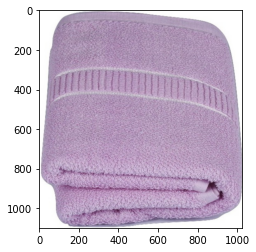

(1027, 1100)
170
Kitchen & Dining categorie : 5
------------------------


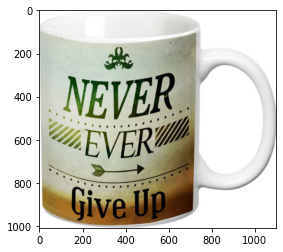

(1100, 1009)
190
Kitchen & Dining categorie : 5
------------------------


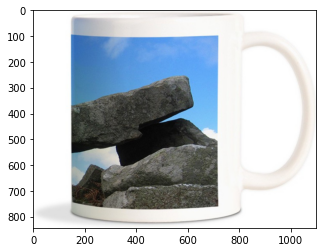

(1100, 844)
673
Baby Care categorie : 0
------------------------


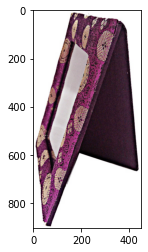

(448, 904)
1038
Home Furnishing categorie : 4
------------------------


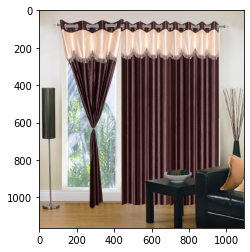

(1093, 1164)


In [11]:
# affichage aléatoire de 5 images avec la catégorie et la taille de l'image

from matplotlib.image import imread
from random import *

for n in range(5):
    i=randint(1,df_.shape[0])
    print(i)
    print(df_.iloc[i-1,1],"categorie :", df_.iloc[i-1,4])
    print("------------------------")
    filename =df_['image_path'][i-1]
    #print(filename)
    #print(df_['image_path'][i])
    image = imread(filename)
    plt.imshow(image)
    plt.show()
    print(image.shape[1::-1])

# 2 : classification supervisée
5 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator sans data augmentation
* Une approche par data generator avec data augmentation. Les images sont directement récupérées à la volée dans le répertoire des images
* Une approche par DataSet(Tensorflow.org) sans data augmentation
* Une approche par DataSet, avec data augmentation intégrée au modèle 


## 2.1 Création du modèle de classification

In [12]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

### 2.2 Modèle avec  préparation initiale des images

In [13]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [14]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(df_['image_path'])) :
        img = (load_img(
            df_['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np =(image_prep_fct(df_))
print(images_np.shape)


C:\Users\serge\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


In [15]:
X = images_np
y =to_categorical(df_['cat_num'])
print(y.shape)

(1050, 7)


In [16]:
# crée train set et test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print (X_train.shape)
X_test,X_val,y_test,y_val=train_test_split(X_test, y_test, test_size=0.6, random_state=42)
print(X_val.shape)
print(X_test.shape)

(787, 224, 224, 3)
(158, 224, 224, 3)
(105, 224, 224, 3)


In [17]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 4.8631 - accuracy: 0.5032
Epoch 1: val_loss improved from inf to 1.43160, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model1_best_weights.h5
25/25 [==============================] - 184s 7s/step - loss: 4.8631 - accuracy: 0.5032 - val_loss: 1.4316 - val_accuracy: 0.7405
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.8315 - accuracy: 0.7065
Epoch 2: val_loss improved from 1.43160 to 1.02933, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model1_best_weights.h5
25/25 [==============================] - 184s 7s/step - loss: 1.8315 - accuracy: 0.7065 - val_loss: 1.0293 - val_accuracy: 0.7785
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.7726
Epoch 3: val_loss improved from 1.02933 to 0.85605, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model1_best_weights.h5
25/

In [19]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

25/25 [==============================] - 156s 6s/step - loss: 0.0140 - accuracy: 0.9962
Training Accuracy: 0.9962

5/5 [==============================] - 30s 6s/step - loss: 0.9762 - accuracy: 0.7785
Validation Accuracy:  0.7785


In [20]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8291
Test Accuracy       :  0.7905


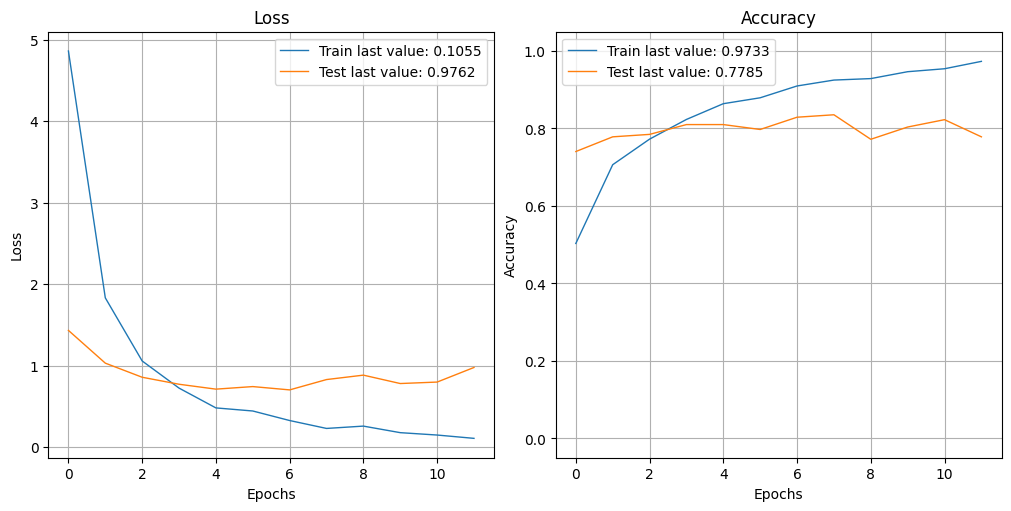

In [21]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)

plot_history(history1, path="standard1.png")
plt.savefig("VGG16 pré-entrainé")
plt.close()

In [22]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)

print(y_val_num)
print()
print(y_val_pred)




5/5 [==============================] - 31s 6s/step
[6 4 6 6 5 0 0 6 0 4 4 0 0 4 5 5 3 5 5 3 3 6 6 2 6 1 6 6 1 6 0 5 6 1 3 5 0
 2 4 0 4 4 6 2 5 3 3 2 1 5 2 0 5 0 2 5 0 1 5 4 4 3 1 5 4 0 2 4 5 4 1 2 0 4
 2 2 1 1 4 5 0 0 1 3 5 6 4 5 3 2 2 2 6 3 2 5 1 6 0 5 2 6 5 2 6 3 2 6 0 2 1
 2 4 2 1 4 1 4 5 2 4 1 3 1 5 4 1 6 6 4 4 6 1 3 5 5 2 2 5 4 6 2 6 4 6 5 6 5
 3 3 1 0 6 0 5 3 0 0]

[6 4 6 6 5 0 4 6 0 4 4 0 0 4 0 2 3 5 5 3 3 6 6 2 6 1 6 6 1 6 0 5 5 1 2 5 0
 2 0 0 4 4 6 2 5 4 3 2 1 5 2 0 5 0 2 5 0 4 5 4 4 2 1 5 4 0 2 4 5 4 1 2 0 4
 2 2 1 1 4 5 4 0 1 5 5 6 0 5 3 2 2 2 6 5 1 5 1 6 0 5 2 2 5 2 2 3 2 6 0 2 1
 2 4 2 1 4 1 4 5 5 0 1 3 1 5 4 2 6 6 0 4 6 1 3 5 5 2 2 5 0 6 2 6 0 6 5 6 4
 3 3 4 4 6 3 5 3 1 0]
[[16  1  0  1  3  0  0]
 [ 0 16  1  0  2  0  0]
 [ 0  1 22  0  0  1  0]
 [ 0  0  2 11  1  2  0]
 [ 6  0  0  0 18  0  0]
 [ 1  0  1  0  1 25  0]
 [ 0  0  2  0  0  1 23]]
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[16  1  0  1  3  0  0]
 [ 0 16  1  0  2  0  0]
 [ 0  1 22  0  0  1  0]
 [ 0  0  2 11  1

In [23]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[16  1  0  1  3  0  0]
 [ 0 16  1  0  2  0  0]
 [ 0  1 22  0  0  1  0]
 [ 0  0  2 11  1  2  0]
 [ 6  0  0  0 18  0  0]
 [ 1  0  1  0  1 25  0]
 [ 0  0  2  0  0  1 23]]


In [24]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[16  1  0  1  3  0  0]
 [ 0 16  1  0  2  0  0]
 [ 0  1 22  0  0  1  0]
 [ 0  0  2 11  1  2  0]
 [ 6  0  0  0 18  0  0]
 [ 1  0  1  0  1 25  0]
 [ 0  0  2  0  0  1 23]]

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.89      0.84      0.86        19
           2       0.79      0.92      0.85        24
           3       0.92      0.69      0.79        16
           4       0.72      0.75      0.73        24
           5       0.86      0.89      0.88        28
           6       1.00      0.88      0.94        26

    accuracy                           0.83       158
   macro avg       0.84      0.82      0.82       158
weighted avg       0.84      0.83      0.83       158



<Axes: >

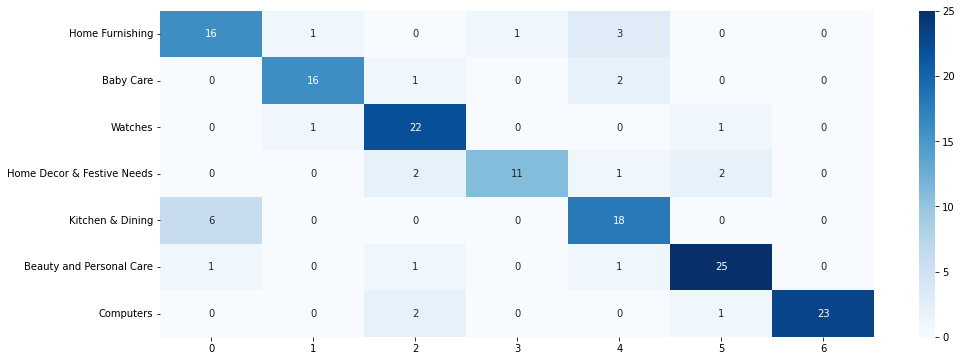

In [27]:
df_cm1=pd.DataFrame(conf_mat, index = [label for label in df_['categorie'].unique()],
                  columns = [i for i in range(7)])
plt.figure(figsize = (16,6))
heat1=sns.heatmap(df_cm1, annot=True, cmap="Blues")
heat1

In [28]:
#création train set , val set et test set
X=df_['image']
y=df_['categorie']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size=0.75, stratify=df_.categorie  , random_state=1234)
X_test, X_val, y_test, y_val =  train_test_split(X_test, y_test, test_size=0.60  , random_state=1234)


In [29]:
print('X_train : ',X_train.shape[0])
print('X_val : ',X_val.shape[0])
print('X_test : ',X_test.shape[0])

X_train :  787
X_val :  158
X_test :  105


### 2.3 Modele avec ImageDataGenérator  sans Data Augmentation

In [32]:

import shutil

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\Flipkart\Images'

# The directory where we will
# store our smaller dataset
base_dir = r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\Flipkart\gen_train'
os.mkdir(base_dir)

category0 = "Home Decor & Festive Needs"
category1 = "Computers"
category2 = "Kitchen & Dining"
category3 = "Home Furnishing"
category4 = "Baby Care"
category5 = "Beauty and Personal Care"
category6 = "Watches"

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


#train par categorie
train_cat0_dir = os.path.join(train_dir, category0)
os.mkdir(train_cat0_dir)
train_cat1_dir = os.path.join(train_dir, category1)
os.mkdir(train_cat1_dir)
train_cat2_dir = os.path.join(train_dir, category2)
os.mkdir(train_cat2_dir)
train_cat3_dir = os.path.join(train_dir, category3)
os.mkdir(train_cat3_dir)
train_cat4_dir = os.path.join(train_dir, category4)
os.mkdir(train_cat4_dir)
train_cat5_dir = os.path.join(train_dir, category5)
os.mkdir(train_cat5_dir)
train_cat6_dir = os.path.join(train_dir, category6)
os.mkdir(train_cat6_dir)

#validation par categorie
val_cat0_dir = os.path.join(validation_dir, category0)
os.mkdir(val_cat0_dir)
val_cat1_dir = os.path.join(validation_dir, category1)
os.mkdir(val_cat1_dir)
val_cat2_dir = os.path.join(validation_dir, category2)
os.mkdir(val_cat2_dir)
val_cat3_dir = os.path.join(validation_dir, category3)
os.mkdir(val_cat3_dir)
val_cat4_dir = os.path.join(validation_dir, category4)
os.mkdir(val_cat4_dir)
val_cat5_dir = os.path.join(validation_dir, category5)
os.mkdir(val_cat5_dir)
val_cat6_dir = os.path.join(validation_dir, category6)
os.mkdir(val_cat6_dir)

#test par categorie
test_cat0_dir = os.path.join(test_dir, category0)
os.mkdir(test_cat0_dir)
test_cat1_dir = os.path.join(test_dir, category1)
os.mkdir(test_cat1_dir)
test_cat2_dir = os.path.join(test_dir, category2)
os.mkdir(test_cat2_dir)
test_cat3_dir = os.path.join(test_dir, category3)
os.mkdir(test_cat3_dir)
test_cat4_dir = os.path.join(test_dir, category4)
os.mkdir(test_cat4_dir)
test_cat5_dir = os.path.join(test_dir, category5)
os.mkdir(test_cat5_dir)
test_cat6_dir = os.path.join(test_dir, category6)
os.mkdir(test_cat6_dir)




In [33]:
import regex as re
for fname, label in zip(X_train, y_train):
    rep=str((df_.loc[df_['image']==fname,['categorie']].values))
    rep=rep.strip("['']")
    path_cat = train_dir+'\\'+rep+'\\'
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(path_cat, fname)
    shutil.copyfile(src, dst)

for fname, label in zip(X_val, y_val):
    rep=str((df_.loc[df_['image']==fname,['categorie']].values))
    rep=rep.strip("['']")
    path_cat = validation_dir+'\\'+rep+'\\'
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(path_cat, fname)
    shutil.copyfile(src, dst)

for fname, label in zip(X_test, y_test):
    rep=str((df_.loc[df_['image']==fname,['categorie']].values))
    rep=rep.strip("['']")
    path_cat = test_dir+'\\'+rep+'\\'
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(path_cat, fname)
    shutil.copyfile(src, dst)

In [34]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

In [35]:
train_generator = datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(224,224),
                                                    class_mode='categorical')

validation_generator = datagen.flow_from_directory(validation_dir,
                                                        batch_size=32,
                                                        target_size=(224, 224),
                                                        class_mode='categorical')

test_generator = datagen.flow_from_directory(test_dir,
                                                 batch_size=32,
                                                target_size=(224, 224),
                                                class_mode='categorical')


Found 787 images belonging to 7 classes.
Found 158 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


On peut vérifier que les lots d'images créés correspondent aux dimensions voulues en utilisant la fonction shape.

In [36]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 7)


On a bien des lots de 32 images de dimensions 224x224x3 et des lots de 32 labels en 7 catégories.

#### 2.3.1 Création du  modèle CNN 

Pour une modélisation avec des images,nous utiliserons un modèle à couches de convolution pré-entrainé sur un dataset d'images.


In [37]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### 2.3.2 Entraînement du modèle

In [38]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_generator,
    epochs=50,batch_size=32,
    validation_data=validation_generator, 
    callbacks=callbacks_list, verbose=1)

Epoch 1/50
 4/25 [===>..........................] - ETA: 1:50 - loss: 1.9644 - accuracy: 0.2087

C:\Users\serge\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 1.6511 - accuracy: 0.3888
Epoch 1: val_loss improved from inf to 1.29611, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model2_best_weights.h5
25/25 [==============================] - 190s 8s/step - loss: 1.6511 - accuracy: 0.3888 - val_loss: 1.2961 - val_accuracy: 0.6013
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2611 - accuracy: 0.5947
Epoch 2: val_loss improved from 1.29611 to 1.05070, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model2_best_weights.h5
25/25 [==============================] - 194s 8s/step - loss: 1.2611 - accuracy: 0.5947 - val_loss: 1.0507 - val_accuracy: 0.6329
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.1022 - accuracy: 0.6442
Epoch 3: val_loss improved from 1.05070 to 0.94607, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model2_best_weights.h5
25/25 [=======

Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.9034
Epoch 25: val_loss did not improve from 0.66173
25/25 [==============================] - 181s 7s/step - loss: 0.3749 - accuracy: 0.9034 - val_loss: 0.6786 - val_accuracy: 0.8038
Epoch 25: early stopping


In [ ]:
#model.save('model2_best_weights.h5')
#model=model.load_model('model2_best_weights.h5')

In [39]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_generator, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(validation_generator, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 153s 6s/step - loss: 0.3103 - accuracy: 0.9072
Training Accuracy   : 0.9072

5/5 [==============================] - 32s 6s/step - loss: 0.6786 - accuracy: 0.8038
Validation Accuracy :  0.8038


In [40]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(validation_generator, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_generator, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7595
Test Accuracy       :  0.8952


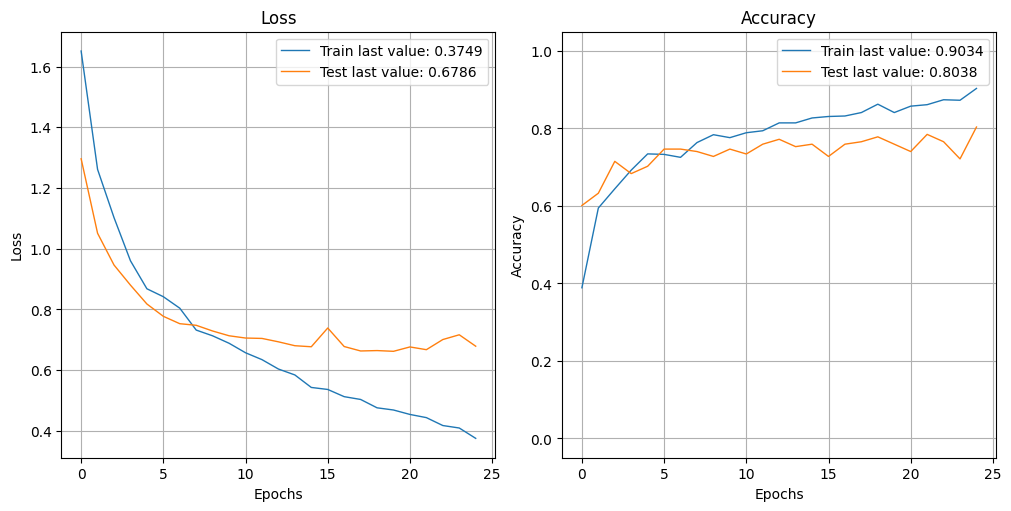

In [41]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard2.png")
plt.close()

Sur les **données d'entraînement**, le modèle est **de plus en plus performant** mais sur les **données de validation** il stagne, voir devient **de moins en moins bon**.

Le modèle **se spécialise sur les données d'entraînement** mais n'est plus capable d'**interpréter** les données de validation (et les données réelles en général), il est en **overfitting**.
Sur les données de test,la précision est de 0.89

L'overfitting est dû au manque de données pour l' entraînement du modèle.
Pour augmenter le nombre de données , on va créer de nouvelles images grâce à la Data Augmentation.
L'idée est de reproduire les données pré-existantes en leur appliquant une transformation aléatoire.
Lors de l'entraînement, le modèle aura plus de données à sa disposition.Ce qui devrait lui permettre de mieux généraliser.

## 2.4 Modèle avec ImageDataGenerator avec  Data Augmentation

On va utiliser la fonction ImageDataGenerator en modifiant certains paramètres pour créer de nouvelles images.

In [42]:
# exemple de filtres pour générer nouvelles images à partir d'images existantes
augmented_datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.25,
      height_shift_range=0.25,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')    # pour affichage

    
Ci-dessous,2 exemples de Data Augmentation à partir de 2 images de la classe 4 (baby care)

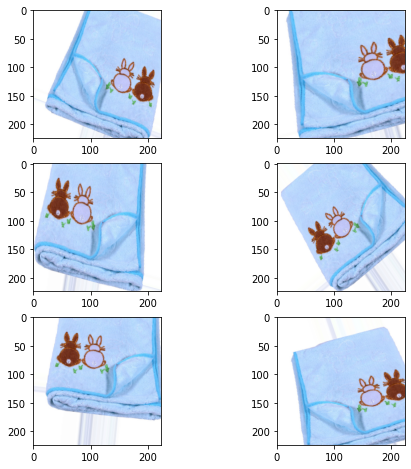

In [43]:
fnames = [os.path.join(train_cat4_dir, fname) for
     fname in os.listdir(train_cat4_dir)]

img_path = fnames[11]
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

x = tf.keras.utils.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(8,8))

for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(tf.keras.utils.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break

plt.show()

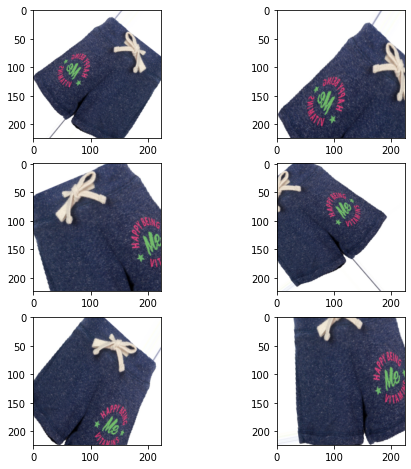

In [44]:
fnames = [os.path.join(train_cat4_dir, fname) for
     fname in os.listdir(train_cat4_dir)]

img_path = fnames[6]
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))

x = tf.keras.utils.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(8,8))

for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(tf.keras.utils.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break

plt.show()

La **Data Augmentation** concerne seulement les **données d'entraînement**... pour les autres données on initialise un **générateur simple** 

In [45]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [46]:
datagen = ImageDataGenerator(rescale=1./255) # générateur simple pour test et val set

On indique le chemin des fichiers contenant les images aux deux générateurs et on configure le preprocessing a effectuer.

In [47]:
train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 787 images belonging to 7 classes.
Found 158 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


#### 2.4.1 Création du modèle et entrainement

On entraîne notre modèle avec 100 epochs car on sait que le modèle ne devrait pas overfitter rapidement grâce à la Data Augmentation.

In [48]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [49]:
with tf.device('/gpu:0'):
    history3 = model3.fit(train_generator,
    epochs=100, batch_size=32,
    validation_data=validation_generator,
  callbacks=callbacks_list, verbose=1)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 1.8004 - accuracy: 0.3050
Epoch 1: val_loss improved from inf to 1.34811, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model3_best_weights.h5
25/25 [==============================] - 201s 8s/step - loss: 1.8004 - accuracy: 0.3050 - val_loss: 1.3481 - val_accuracy: 0.6772
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.4700 - accuracy: 0.4803
Epoch 2: val_loss improved from 1.34811 to 1.13332, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model3_best_weights.h5
25/25 [==============================] - 194s 8s/step - loss: 1.4700 - accuracy: 0.4803 - val_loss: 1.1333 - val_accuracy: 0.6709
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.2755 - accuracy: 0.5820
Epoch 3: val_loss improved from 1.13332 to 1.01430, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model3_best_weights.h5


In [50]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(train_generator, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(validation_generator, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 159s 6s/step - loss: 0.6625 - accuracy: 0.7929
Training Accuracy   : 0.7929

5/5 [==============================] - 31s 6s/step - loss: 0.7320 - accuracy: 0.7468
Validation Accuracy :  0.7468


In [51]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(validation_generator, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(test_generator, verbose=True)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7152
4/4 [==============================] - 21s 5s/step - loss: 0.4902 - accuracy: 0.8571
Test Accuracy       :  0.8571


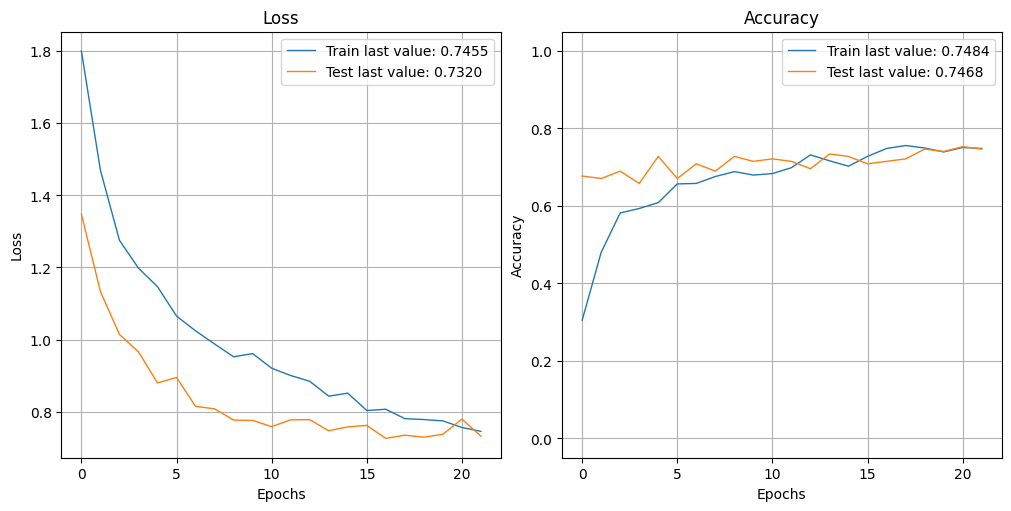

In [52]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard3.png")
plt.close()

Le modèle overfit beaucoup moins et beaucoups moins vite.
 
On vérifie sur les données de test,la perte de 0.73 et la précision 0.75.

## 2.5 Modèle avec Dataset sans data augmentation

In [14]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=1234,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [15]:
path=r'C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P6\\Flipkart\\Images'
path1=r'C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P6\\Flipkart'
path2=path1+'\\gen_train'
path_train=path2+'\\train'
path_test=path2+'\\test'
path_val=path2+'\\validation'

In [16]:
dataset_train = dataset_fct(path_train,validation_split=0, data_type=None)
dataset_val = dataset_fct(path_val, validation_split=0, data_type=None)
dataset_test = dataset_fct(path_test,validation_split=0., data_type=None)

Found 787 files belonging to 7 classes.
Found 158 files belonging to 7 classes.
Found 105 files belonging to 7 classes.


#### 2.5.1 Création du modèle et entrainement

In [56]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct()

# Création du callback
model4_save_path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 5.4382 - accuracy: 0.5006
Epoch 1: val_loss improved from inf to 1.41220, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model4_best_weights.h5
25/25 [==============================] - 186s 7s/step - loss: 5.4382 - accuracy: 0.5006 - val_loss: 1.4122 - val_accuracy: 0.7215
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.9962 - accuracy: 0.7052
Epoch 2: val_loss improved from 1.41220 to 1.18876, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model4_best_weights.h5
25/25 [==============================] - 184s 7s/step - loss: 1.9962 - accuracy: 0.7052 - val_loss: 1.1888 - val_accuracy: 0.7722
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.2826 - accuracy: 0.7560
Epoch 3: val_loss improved from 1.18876 to 1.08295, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model4_best_weights.h5
25/

In [58]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 154s 6s/step - loss: 0.0354 - accuracy: 0.9898
Training Accuracy   : 0.9898

5/5 [==============================] - 30s 6s/step - loss: 1.0605 - accuracy: 0.8038
Validation Accuracy :  0.8038


In [59]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7911
Test Accuracy       :  0.8667


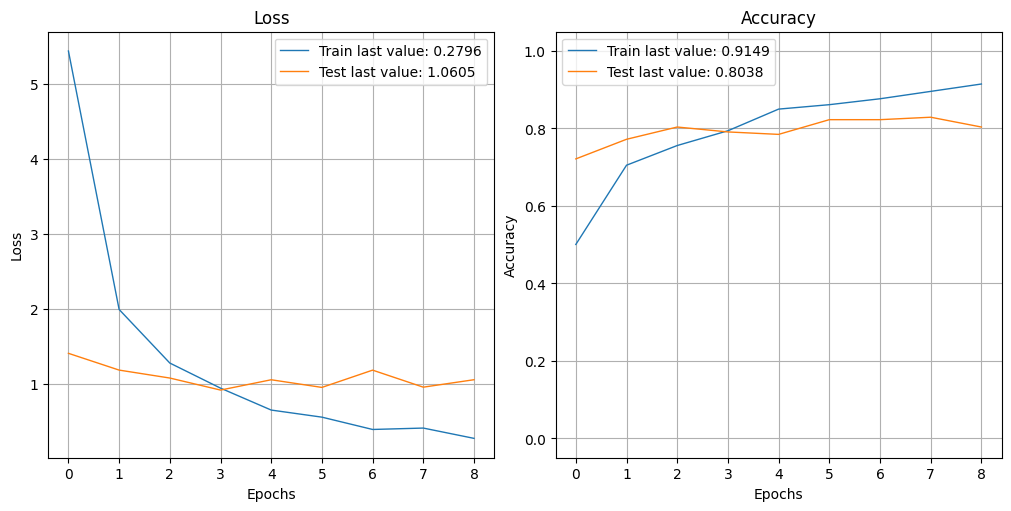

In [60]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard4.png")
plt.close()

## 2.6 Modèle avec  Dataset et Data Augmentation intégrée au modèle

In [17]:
dataset_train = dataset_fct(path_train,validation_split=0, data_type=None)
dataset_val = dataset_fct(path_val, validation_split=0, data_type=None)
dataset_test = dataset_fct(path_test,validation_split=0., data_type=None)

Found 787 files belonging to 7 classes.
Found 158 files belonging to 7 classes.
Found 105 files belonging to 7 classes.


In [18]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [19]:
dataset_val

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [20]:
dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [21]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("vertical", input_shape=(224, 224, 3)),
        RandomRotation(0.2),
        RandomZoom(0.2),
               
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    print(model.summary())
    
    return model
    

#### 2.6.1 Création du modèle et entrainement

In [22]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = create_model_fct2()

# Création du callback
model5_save_path = r"C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model5_best_weights.h5"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [23]:
with tf.device('/gpu:0'): 
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8881 - accuracy: 0.2529
Epoch 1: val_loss improved from inf to 1.45457, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model5_best_weights.h5
25/25 [==============================] - 211s 8s/step - loss: 1.8881 - accuracy: 0.2529 - val_loss: 1.4546 - val_accuracy: 0.6203
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4751 - accuracy: 0.4943
Epoch 2: val_loss improved from 1.45457 to 1.17171, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model5_best_weights.h5
25/25 [==============================] - 216s 8s/step - loss: 1.4751 - accuracy: 0.4943 - val_loss: 1.1717 - val_accuracy: 0.6456
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.2976 - accuracy: 0.5820
Epoch 3: val_loss improved from 1.17171 to 1.00798, saving model to C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P6\model5_best_weights.h5
25/

In [24]:
# Score du dernier epoch

loss, accuracy = model5.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model5.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 170s 7s/step - loss: 0.4300 - accuracy: 0.8793
Training Accuracy   : 0.8793

5/5 [==============================] - 36s 6s/step - loss: 0.6329 - accuracy: 0.7785
Validation Accuracy :  0.7785


In [25]:
# Score de l'epoch optimal

model5.load_weights(model5_save_path)

loss, accuracy = model5.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model5.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7722
Test Accuracy       :  0.8857


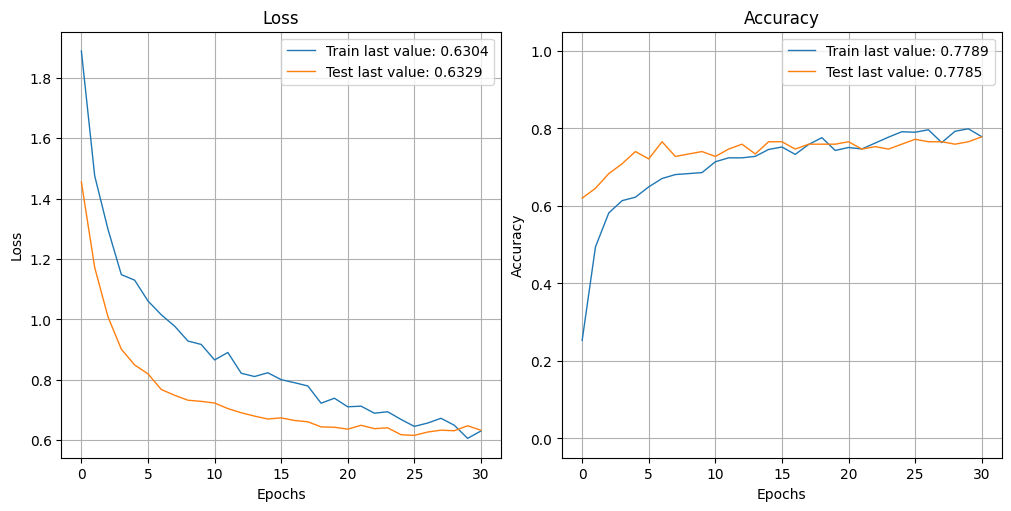

In [27]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history5)
plot_history(history5, path="standard5.png")
plt.close()

# 3 résultats généraux des  modèles de classification 

In [83]:
# tableau récapitulatif
perfo_texte=pd.read_csv(r'C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P6\\performances_texte.csv')
perfs = pd.concat(
  [perfo_texte,
  pd.DataFrame(
             {"Mean accuracy":[0.829,0.756,0.715,0.791,0.772],
     
              "Unnamed: 0":  ['Préparation images','IMAGEDATAGENERATOR sans data augmentation',
             'IMAGEDATAGENERATOR avec data augmentation', 'DATASET sans data augmentation',
             'DATASET avec data augmentation intégrée']},
      index=[5,6,7,8,9])]
     
).sort_values("Mean accuracy",ascending = False).rename(columns={"Unnamed: 0": "Modeles","Mean accuracy":"Accuracy"})      
perfs.reset_index(drop =True)

,Modeles,Accuracy
0,Contextual Embedding,0.920357
1,TF-IDF,0.914782
2,Bag-of-Words,0.905838
3,Word2Vec pré-entraîné,0.884489
4,Préparation images,0.829000
5,DATASET sans data augmentation,0.791000
6,DATASET avec data augmentation intégrée,0.772000
7,IMAGEDATAGENERATOR sans data augmentation,0.756000
8,IMAGEDATAGENERATOR avec data augmentation,0.715000
9,Word2Vec non pré-entraîné,0.469719


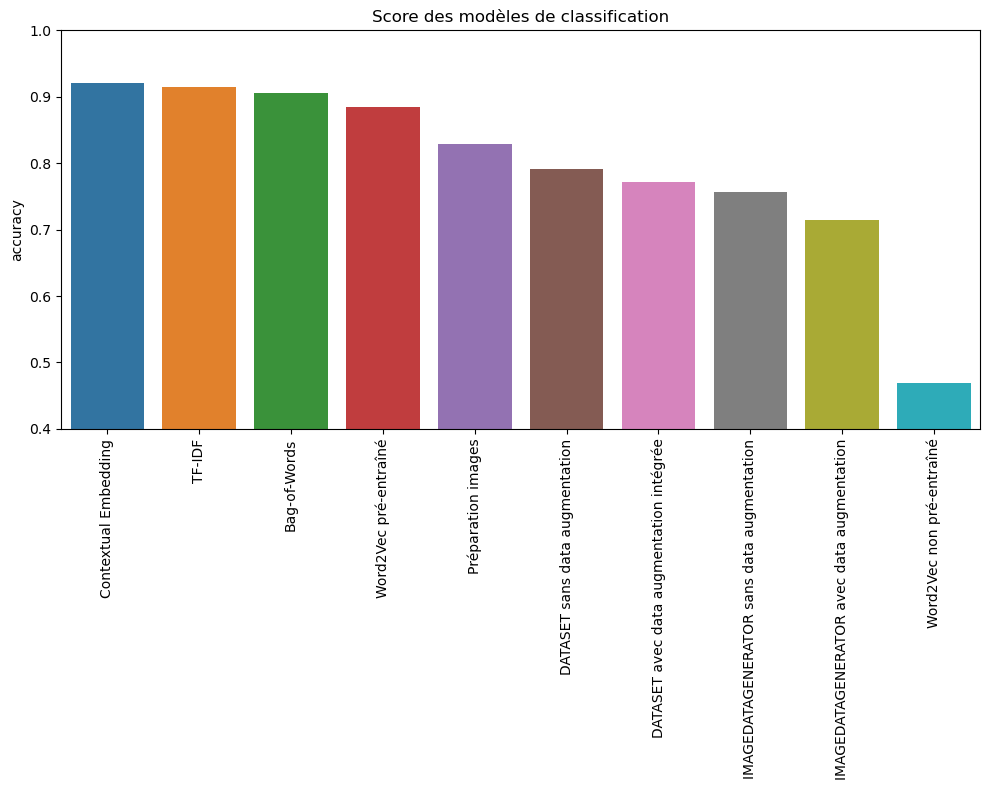

In [85]:
# graphique accuracy des modeles de classification supervisée
plt.figure(figsize=(10, 8))
sns.barplot(x = perfs['Modeles'],
            y = perfs['Accuracy'])
plt.title('Score des modèles de classification')
plt.xlabel('')
plt.ylabel('accuracy')
plt.ylim(0.40,1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('performance final.jpg')
plt.show()